In [ ]:
## Python Script for the Final Project, Stats 506 F20
##
## For adults who weigh less than they were 10 years ago, what types of nutrient
## intake and what demographic variables play an important role?
##
## Data source: National Health and Nutrition Examination Survey (NHANES)
## https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016
## https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018 
##
## Author: Yingyi Yang, yyingyi@umich.edu
## Updated: December 6, 2020

#! Limit lines to 79 characters with rare exceptions. 
# 79: -------------------------------------------------------------------------

In [86]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [113]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

### 1. Data preprocessing 

In [89]:
def prep_data(year):
    
    base = 'data/'
    
    files = []
    
    var = [
        ['SEQN', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2', 'INDHHIN2'],
        ['SEQN', 'DR1DRSTZ', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 
         'DR1TTFAT', 'DR1TCHOL'],
        ['SEQN', 'WHD020', 'WHD110']
    ]
    
    out = pd.DataFrame()
    for code in year:
        names = [x+'_'+code+'.XPT' for x in ['DEMO', 'DR1TOT', 'WHQ']]

        da = []
        for idf, fn in enumerate(names):
            df = pd.read_sas(os.path.join(base, fn))
            df = df.loc[:, var[idf]]
            da.append(df)
            
        dx = pd.merge(da[0], da[1], left_on='SEQN', right_on='SEQN')
        dx = pd.merge(dx, da[2], left_on='SEQN', right_on='SEQN')

        # encode sex and ethnic groups
        dx['Female'] = (dx.RIAGENDR == 2).astype(np.int)
        #dx['RIDRETH1'] = dx.RIDRETH1.replace({1: 'Mexican American', 2: 'Other Hispanic', 
        #                                      3: 'Non-Hispanic White', 4: 'Non-Hispanic Black', 
        #                                      5: 'other'})
        
        dx.dropna(inplace = True)
        out = out.append(dx)
    
    out['Wloss'] = (out['WHD020'] < out['WHD110']-5.0).astype(np.int)
    del out['RIAGENDR']
    del out['WHD020']
    del out['WHD110']
    out.set_index('SEQN', inplace=True)
    
    return out    

In [90]:
df = prep_data(['I','J'])
df.shape

(6983, 15)

### 2. Feature selection 

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
import seaborn as sns

In [122]:
def featureSelection(data, n, method = 'Model_LR'):
    
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    if method == 'Model_LR':
        LR = LogisticRegression()
        LR.fit(X, y)
        coefs = LR.coef_
        feature_coefs = pd.DataFrame({'Feature name':X.columns.values, 
                                      'Feature coef':coefs[0]}).sort_values('Feature coef', ascending=False)

        imp_coef = pd.concat([feature_coefs.head(int(n/2)),
                             feature_coefs.tail(int(n/2))])

        plt.figure(figsize=(6,6))
        plt.title("Coefficients")
        sns.barplot(x="Feature coef", y="Feature name", data=imp_coef)  
    
    if method == 'Model_tree':
        tree = DecisionTreeClassifier()
        tree.fit(X, y)      
        importances = tree.feature_importances_
        feature_importance = pd.DataFrame({'Feature name':X.columns.values, 
                                           'Feature importance':importances}
                                         ).sort_values('Feature importance', ascending=False)

        plt.figure(figsize=(6,6))
        plt.title("Feature Importance")
        sns.barplot(x="Feature importance", y="Feature name", data=feature_importance[:n])
        
    if method == 'RFE_LR':
        LR = LogisticRegression()
        trans = RFE(LR, n_features_to_select=n)
        X_trans = trans.fit_transform(X, y)
        print(trans)
        columns_retained = data.iloc[:,:-1].columns[trans.get_support()].values
        print(columns_retained)
        
    if method == 'RFE_tree':
        tree = DecisionTreeClassifier()
        trans = RFE(tree, n_features_to_select=n)
        X_trans = trans.fit_transform(X, y)
        columns_retained = data.iloc[:,:-1].columns[trans.get_support()].values
        print(columns_retained)        

### 3. Results visualization 

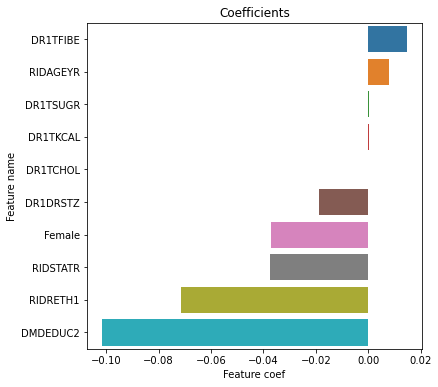

In [116]:
featureSelection(df, 10, 'Model_LR')

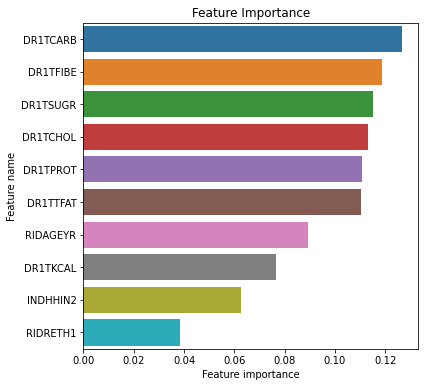

In [117]:
featureSelection(df, 10, 'Model_tree')

In [123]:
featureSelection(df, 10, 'RFE_LR')

RFE(estimator=LogisticRegression(), n_features_to_select=10)
['RIDSTATR' 'RIDAGEYR' 'RIDRETH1' 'DMDEDUC2' 'INDHHIN2' 'DR1DRSTZ'
 'DR1TPROT' 'DR1TFIBE' 'DR1TTFAT' 'Female']


In [119]:
featureSelection(df, 10, 'RFE_tree')

['RIDAGEYR' 'RIDRETH1' 'INDHHIN2' 'DR1TKCAL' 'DR1TPROT' 'DR1TCARB'
 'DR1TSUGR' 'DR1TFIBE' 'DR1TTFAT' 'DR1TCHOL']
